# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

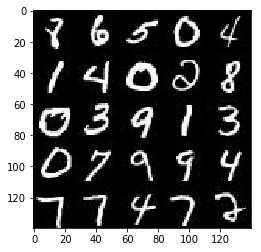

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

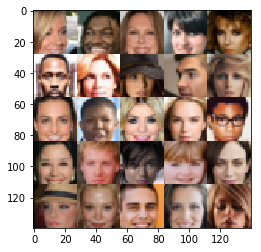

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/tapanm01/anaconda2/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='Z_input')
    learning_rate = tf.placeholder(tf.float32, name='Learning_Rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256
        
        #x4 = tf.layers.conv2d(relu3, filters=512, kernel_size=5, strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(0.2 * bn4, bn4)
        # 2x2x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        #x1 = tf.layers.dense(z, 2*2*512,activation=tf.nn.relu)
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.01 * x3, x3)
        # 28x28x128 now

        #x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=2, padding='same')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(0.2 * x4, x4)
        # 14x14x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #input_real, input_z, lr = model_inputs(28, 28, out_channel_dim, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    #d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    #d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    

    sample_z = np.random.uniform(-1, out_channel_dim, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, out_channel_dim, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                #_ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}    ".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps 10     Discriminator Loss: 1.3302... Generator Loss: 0.3226
Epoch 1/2... Steps 20     Discriminator Loss: 0.4717... Generator Loss: 2.6740
Epoch 1/2... Steps 30     Discriminator Loss: 0.7556... Generator Loss: 4.8648
Epoch 1/2... Steps 40     Discriminator Loss: 1.9002... Generator Loss: 0.3418
Epoch 1/2... Steps 50     Discriminator Loss: 2.2053... Generator Loss: 0.1604
Epoch 1/2... Steps 60     Discriminator Loss: 2.5708... Generator Loss: 0.1122
Epoch 1/2... Steps 70     Discriminator Loss: 1.9736... Generator Loss: 0.1980
Epoch 1/2... Steps 80     Discriminator Loss: 2.1378... Generator Loss: 0.1907
Epoch 1/2... Steps 90     Discriminator Loss: 1.8483... Generator Loss: 0.2339
Epoch 1/2... Steps 100     Discriminator Loss: 1.7197... Generator Loss: 0.2863


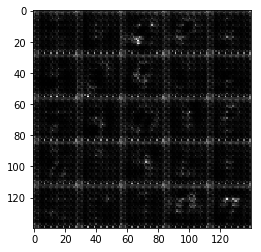

Epoch 1/2... Steps 110     Discriminator Loss: 1.6384... Generator Loss: 0.3239
Epoch 1/2... Steps 120     Discriminator Loss: 1.7148... Generator Loss: 0.2886
Epoch 1/2... Steps 130     Discriminator Loss: 1.8991... Generator Loss: 0.2155
Epoch 1/2... Steps 140     Discriminator Loss: 1.7203... Generator Loss: 0.3219
Epoch 1/2... Steps 150     Discriminator Loss: 1.5435... Generator Loss: 0.3730
Epoch 1/2... Steps 160     Discriminator Loss: 1.7030... Generator Loss: 0.2770
Epoch 1/2... Steps 170     Discriminator Loss: 1.6111... Generator Loss: 0.3395
Epoch 1/2... Steps 180     Discriminator Loss: 1.5314... Generator Loss: 0.3554
Epoch 1/2... Steps 190     Discriminator Loss: 1.5839... Generator Loss: 0.3287
Epoch 1/2... Steps 200     Discriminator Loss: 1.5708... Generator Loss: 0.3341


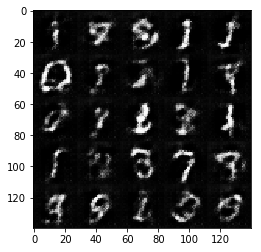

Epoch 1/2... Steps 210     Discriminator Loss: 1.4891... Generator Loss: 0.3818
Epoch 1/2... Steps 220     Discriminator Loss: 1.6616... Generator Loss: 0.2851
Epoch 1/2... Steps 230     Discriminator Loss: 1.4683... Generator Loss: 0.4054
Epoch 1/2... Steps 240     Discriminator Loss: 1.6847... Generator Loss: 0.2758
Epoch 1/2... Steps 250     Discriminator Loss: 1.5033... Generator Loss: 0.4051
Epoch 1/2... Steps 260     Discriminator Loss: 1.7599... Generator Loss: 0.2543
Epoch 1/2... Steps 270     Discriminator Loss: 1.4194... Generator Loss: 0.4610
Epoch 1/2... Steps 280     Discriminator Loss: 1.6054... Generator Loss: 0.3024
Epoch 1/2... Steps 290     Discriminator Loss: 1.6193... Generator Loss: 0.3037
Epoch 1/2... Steps 300     Discriminator Loss: 1.4208... Generator Loss: 0.4108


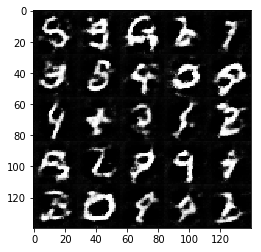

Epoch 1/2... Steps 310     Discriminator Loss: 1.5495... Generator Loss: 0.3466
Epoch 1/2... Steps 320     Discriminator Loss: 1.5368... Generator Loss: 0.3769
Epoch 1/2... Steps 330     Discriminator Loss: 1.5964... Generator Loss: 0.3333
Epoch 1/2... Steps 340     Discriminator Loss: 1.6621... Generator Loss: 0.2814
Epoch 1/2... Steps 350     Discriminator Loss: 1.4701... Generator Loss: 0.4147
Epoch 1/2... Steps 360     Discriminator Loss: 1.4932... Generator Loss: 0.3881
Epoch 1/2... Steps 370     Discriminator Loss: 1.5404... Generator Loss: 0.3309
Epoch 1/2... Steps 380     Discriminator Loss: 1.4259... Generator Loss: 0.4190
Epoch 1/2... Steps 390     Discriminator Loss: 1.6155... Generator Loss: 0.3049
Epoch 1/2... Steps 400     Discriminator Loss: 1.8828... Generator Loss: 0.2216


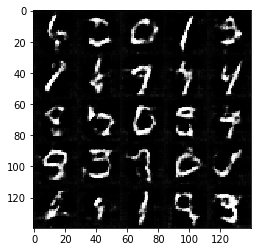

Epoch 1/2... Steps 410     Discriminator Loss: 1.3173... Generator Loss: 0.5886
Epoch 1/2... Steps 420     Discriminator Loss: 1.3092... Generator Loss: 0.8583
Epoch 1/2... Steps 430     Discriminator Loss: 1.5668... Generator Loss: 1.1576
Epoch 1/2... Steps 440     Discriminator Loss: 1.3707... Generator Loss: 0.9632
Epoch 1/2... Steps 450     Discriminator Loss: 1.4464... Generator Loss: 0.9273
Epoch 1/2... Steps 460     Discriminator Loss: 1.5261... Generator Loss: 1.1805
Epoch 1/2... Steps 470     Discriminator Loss: 1.4345... Generator Loss: 1.1156
Epoch 1/2... Steps 480     Discriminator Loss: 1.3180... Generator Loss: 1.0758
Epoch 1/2... Steps 490     Discriminator Loss: 1.4200... Generator Loss: 1.1267
Epoch 1/2... Steps 500     Discriminator Loss: 1.3513... Generator Loss: 0.7536


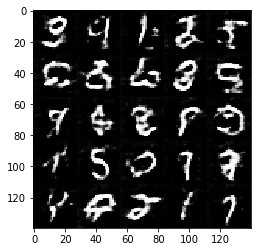

Epoch 1/2... Steps 510     Discriminator Loss: 1.4293... Generator Loss: 1.1654
Epoch 1/2... Steps 520     Discriminator Loss: 1.3287... Generator Loss: 0.7946
Epoch 1/2... Steps 530     Discriminator Loss: 1.5135... Generator Loss: 0.9584
Epoch 1/2... Steps 540     Discriminator Loss: 1.3544... Generator Loss: 0.9766
Epoch 1/2... Steps 550     Discriminator Loss: 1.4524... Generator Loss: 1.2590
Epoch 1/2... Steps 560     Discriminator Loss: 1.3931... Generator Loss: 1.0794
Epoch 1/2... Steps 570     Discriminator Loss: 1.2218... Generator Loss: 0.8157
Epoch 1/2... Steps 580     Discriminator Loss: 1.3000... Generator Loss: 1.0650
Epoch 1/2... Steps 590     Discriminator Loss: 1.5497... Generator Loss: 1.3309
Epoch 1/2... Steps 600     Discriminator Loss: 1.2718... Generator Loss: 0.7229


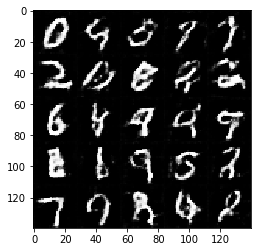

Epoch 1/2... Steps 610     Discriminator Loss: 1.5379... Generator Loss: 1.0927
Epoch 1/2... Steps 620     Discriminator Loss: 1.2976... Generator Loss: 0.9347
Epoch 1/2... Steps 630     Discriminator Loss: 1.3858... Generator Loss: 1.1086
Epoch 1/2... Steps 640     Discriminator Loss: 1.2834... Generator Loss: 0.9909
Epoch 1/2... Steps 650     Discriminator Loss: 1.4175... Generator Loss: 1.1467
Epoch 1/2... Steps 660     Discriminator Loss: 1.3375... Generator Loss: 0.9955
Epoch 1/2... Steps 670     Discriminator Loss: 1.2982... Generator Loss: 0.7874
Epoch 1/2... Steps 680     Discriminator Loss: 1.2871... Generator Loss: 1.1404
Epoch 1/2... Steps 690     Discriminator Loss: 1.3321... Generator Loss: 0.7540
Epoch 1/2... Steps 700     Discriminator Loss: 1.2757... Generator Loss: 0.8361


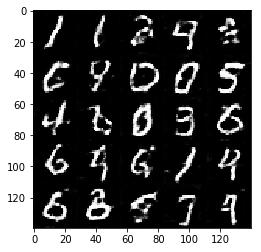

Epoch 1/2... Steps 710     Discriminator Loss: 1.5028... Generator Loss: 1.1512
Epoch 1/2... Steps 720     Discriminator Loss: 1.3080... Generator Loss: 0.8528
Epoch 1/2... Steps 730     Discriminator Loss: 1.3267... Generator Loss: 0.9647
Epoch 1/2... Steps 740     Discriminator Loss: 1.3607... Generator Loss: 1.0117
Epoch 1/2... Steps 750     Discriminator Loss: 1.4538... Generator Loss: 1.1251
Epoch 1/2... Steps 760     Discriminator Loss: 1.3186... Generator Loss: 1.0230
Epoch 1/2... Steps 770     Discriminator Loss: 1.3079... Generator Loss: 0.9774
Epoch 1/2... Steps 780     Discriminator Loss: 1.5912... Generator Loss: 1.3692
Epoch 1/2... Steps 790     Discriminator Loss: 1.2527... Generator Loss: 0.6416
Epoch 1/2... Steps 800     Discriminator Loss: 1.4196... Generator Loss: 1.3257


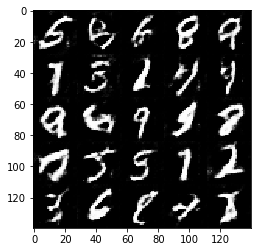

Epoch 1/2... Steps 810     Discriminator Loss: 1.3742... Generator Loss: 0.9340
Epoch 1/2... Steps 820     Discriminator Loss: 1.4829... Generator Loss: 1.3062
Epoch 1/2... Steps 830     Discriminator Loss: 1.2434... Generator Loss: 0.8673
Epoch 1/2... Steps 840     Discriminator Loss: 1.4074... Generator Loss: 1.2502
Epoch 1/2... Steps 850     Discriminator Loss: 1.3265... Generator Loss: 1.1308
Epoch 1/2... Steps 860     Discriminator Loss: 1.3092... Generator Loss: 0.9865
Epoch 1/2... Steps 870     Discriminator Loss: 1.3486... Generator Loss: 0.9335
Epoch 1/2... Steps 880     Discriminator Loss: 1.4585... Generator Loss: 1.4938
Epoch 1/2... Steps 890     Discriminator Loss: 1.1650... Generator Loss: 0.9149
Epoch 1/2... Steps 900     Discriminator Loss: 1.5359... Generator Loss: 1.3874


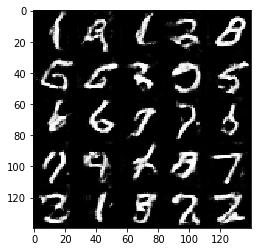

Epoch 1/2... Steps 910     Discriminator Loss: 1.3425... Generator Loss: 0.9447
Epoch 1/2... Steps 920     Discriminator Loss: 1.3810... Generator Loss: 1.2032
Epoch 1/2... Steps 930     Discriminator Loss: 1.1757... Generator Loss: 1.0936
Epoch 2/2... Steps 940     Discriminator Loss: 1.2494... Generator Loss: 0.8279
Epoch 2/2... Steps 950     Discriminator Loss: 1.5931... Generator Loss: 0.3435
Epoch 2/2... Steps 960     Discriminator Loss: 1.4059... Generator Loss: 0.4135
Epoch 2/2... Steps 970     Discriminator Loss: 1.7169... Generator Loss: 0.2706
Epoch 2/2... Steps 980     Discriminator Loss: 1.5628... Generator Loss: 0.3905
Epoch 2/2... Steps 990     Discriminator Loss: 1.7183... Generator Loss: 0.2480
Epoch 2/2... Steps 1000     Discriminator Loss: 1.4184... Generator Loss: 0.4099


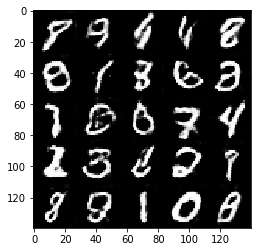

Epoch 2/2... Steps 1010     Discriminator Loss: 1.3182... Generator Loss: 0.4798
Epoch 2/2... Steps 1020     Discriminator Loss: 1.5954... Generator Loss: 0.3088
Epoch 2/2... Steps 1030     Discriminator Loss: 1.5626... Generator Loss: 0.3214
Epoch 2/2... Steps 1040     Discriminator Loss: 1.5296... Generator Loss: 0.3472
Epoch 2/2... Steps 1050     Discriminator Loss: 1.4670... Generator Loss: 0.3696
Epoch 2/2... Steps 1060     Discriminator Loss: 1.4130... Generator Loss: 0.4430
Epoch 2/2... Steps 1070     Discriminator Loss: 1.5143... Generator Loss: 0.3550
Epoch 2/2... Steps 1080     Discriminator Loss: 1.2813... Generator Loss: 0.5693
Epoch 2/2... Steps 1090     Discriminator Loss: 1.4244... Generator Loss: 0.4016
Epoch 2/2... Steps 1100     Discriminator Loss: 1.4135... Generator Loss: 0.3914


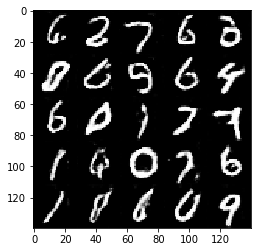

Epoch 2/2... Steps 1110     Discriminator Loss: 1.3471... Generator Loss: 0.4452
Epoch 2/2... Steps 1120     Discriminator Loss: 1.4764... Generator Loss: 0.3580
Epoch 2/2... Steps 1130     Discriminator Loss: 1.4443... Generator Loss: 0.3605
Epoch 2/2... Steps 1140     Discriminator Loss: 1.3900... Generator Loss: 0.4089
Epoch 2/2... Steps 1150     Discriminator Loss: 1.7507... Generator Loss: 0.2525
Epoch 2/2... Steps 1160     Discriminator Loss: 1.4077... Generator Loss: 0.4379
Epoch 2/2... Steps 1170     Discriminator Loss: 1.1370... Generator Loss: 0.7265
Epoch 2/2... Steps 1180     Discriminator Loss: 1.4366... Generator Loss: 1.6392
Epoch 2/2... Steps 1190     Discriminator Loss: 1.3019... Generator Loss: 0.8824
Epoch 2/2... Steps 1200     Discriminator Loss: 1.1083... Generator Loss: 0.9827


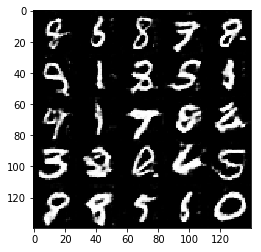

Epoch 2/2... Steps 1210     Discriminator Loss: 1.3267... Generator Loss: 1.0845
Epoch 2/2... Steps 1220     Discriminator Loss: 1.2491... Generator Loss: 1.0406
Epoch 2/2... Steps 1230     Discriminator Loss: 1.1812... Generator Loss: 1.2873
Epoch 2/2... Steps 1240     Discriminator Loss: 1.2653... Generator Loss: 1.0606
Epoch 2/2... Steps 1250     Discriminator Loss: 1.2034... Generator Loss: 0.8441
Epoch 2/2... Steps 1260     Discriminator Loss: 1.3441... Generator Loss: 1.1314
Epoch 2/2... Steps 1270     Discriminator Loss: 1.2390... Generator Loss: 0.7702
Epoch 2/2... Steps 1280     Discriminator Loss: 1.3050... Generator Loss: 0.9000
Epoch 2/2... Steps 1290     Discriminator Loss: 1.2360... Generator Loss: 0.9479
Epoch 2/2... Steps 1300     Discriminator Loss: 1.3662... Generator Loss: 1.2390


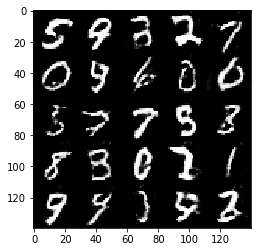

Epoch 2/2... Steps 1310     Discriminator Loss: 1.1540... Generator Loss: 1.2101
Epoch 2/2... Steps 1320     Discriminator Loss: 1.3096... Generator Loss: 1.1663
Epoch 2/2... Steps 1330     Discriminator Loss: 1.3503... Generator Loss: 0.9892
Epoch 2/2... Steps 1340     Discriminator Loss: 1.4458... Generator Loss: 1.3009
Epoch 2/2... Steps 1350     Discriminator Loss: 1.1492... Generator Loss: 0.9082
Epoch 2/2... Steps 1360     Discriminator Loss: 1.0763... Generator Loss: 0.8814
Epoch 2/2... Steps 1370     Discriminator Loss: 0.9891... Generator Loss: 1.0558
Epoch 2/2... Steps 1380     Discriminator Loss: 1.3702... Generator Loss: 0.7096
Epoch 2/2... Steps 1390     Discriminator Loss: 1.4701... Generator Loss: 0.3819
Epoch 2/2... Steps 1400     Discriminator Loss: 1.3855... Generator Loss: 0.4106


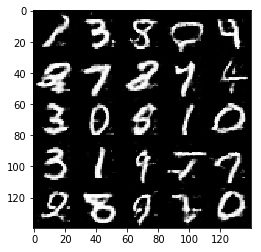

Epoch 2/2... Steps 1410     Discriminator Loss: 1.2566... Generator Loss: 0.5442
Epoch 2/2... Steps 1420     Discriminator Loss: 1.4263... Generator Loss: 0.3800
Epoch 2/2... Steps 1430     Discriminator Loss: 0.9554... Generator Loss: 1.0797
Epoch 2/2... Steps 1440     Discriminator Loss: 1.2922... Generator Loss: 1.3346
Epoch 2/2... Steps 1450     Discriminator Loss: 1.1364... Generator Loss: 1.2320
Epoch 2/2... Steps 1460     Discriminator Loss: 1.2415... Generator Loss: 1.0160
Epoch 2/2... Steps 1470     Discriminator Loss: 1.2652... Generator Loss: 0.9567
Epoch 2/2... Steps 1480     Discriminator Loss: 1.3013... Generator Loss: 1.1721
Epoch 2/2... Steps 1490     Discriminator Loss: 0.9928... Generator Loss: 0.9662
Epoch 2/2... Steps 1500     Discriminator Loss: 1.5405... Generator Loss: 0.3121


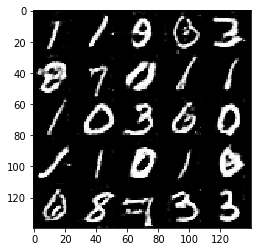

Epoch 2/2... Steps 1510     Discriminator Loss: 1.9844... Generator Loss: 0.1948
Epoch 2/2... Steps 1520     Discriminator Loss: 1.1570... Generator Loss: 0.6439
Epoch 2/2... Steps 1530     Discriminator Loss: 1.5849... Generator Loss: 0.3121
Epoch 2/2... Steps 1540     Discriminator Loss: 1.6923... Generator Loss: 0.2619
Epoch 2/2... Steps 1550     Discriminator Loss: 0.9889... Generator Loss: 0.7717
Epoch 2/2... Steps 1560     Discriminator Loss: 2.3938... Generator Loss: 2.5948
Epoch 2/2... Steps 1570     Discriminator Loss: 1.1321... Generator Loss: 1.2496
Epoch 2/2... Steps 1580     Discriminator Loss: 1.2286... Generator Loss: 1.1975
Epoch 2/2... Steps 1590     Discriminator Loss: 1.1864... Generator Loss: 0.9056
Epoch 2/2... Steps 1600     Discriminator Loss: 1.2527... Generator Loss: 1.2156


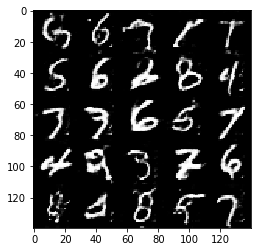

Epoch 2/2... Steps 1610     Discriminator Loss: 1.2257... Generator Loss: 1.0391
Epoch 2/2... Steps 1620     Discriminator Loss: 1.1738... Generator Loss: 1.0657
Epoch 2/2... Steps 1630     Discriminator Loss: 1.1221... Generator Loss: 0.7222
Epoch 2/2... Steps 1640     Discriminator Loss: 1.7692... Generator Loss: 0.2240
Epoch 2/2... Steps 1650     Discriminator Loss: 1.2230... Generator Loss: 0.4719
Epoch 2/2... Steps 1660     Discriminator Loss: 1.7155... Generator Loss: 0.2485
Epoch 2/2... Steps 1670     Discriminator Loss: 1.3996... Generator Loss: 0.4128
Epoch 2/2... Steps 1680     Discriminator Loss: 1.3821... Generator Loss: 0.4282
Epoch 2/2... Steps 1690     Discriminator Loss: 1.3600... Generator Loss: 0.4479
Epoch 2/2... Steps 1700     Discriminator Loss: 1.2384... Generator Loss: 0.6799


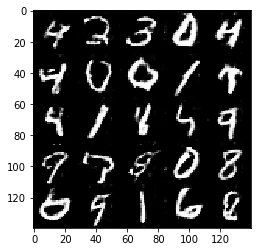

Epoch 2/2... Steps 1710     Discriminator Loss: 1.1993... Generator Loss: 0.8546
Epoch 2/2... Steps 1720     Discriminator Loss: 1.3091... Generator Loss: 1.3059
Epoch 2/2... Steps 1730     Discriminator Loss: 1.0998... Generator Loss: 0.7116
Epoch 2/2... Steps 1740     Discriminator Loss: 1.9249... Generator Loss: 0.2127
Epoch 2/2... Steps 1750     Discriminator Loss: 1.2993... Generator Loss: 0.4975
Epoch 2/2... Steps 1760     Discriminator Loss: 1.3170... Generator Loss: 0.4768
Epoch 2/2... Steps 1770     Discriminator Loss: 1.2601... Generator Loss: 0.4906
Epoch 2/2... Steps 1780     Discriminator Loss: 1.2788... Generator Loss: 0.5325
Epoch 2/2... Steps 1790     Discriminator Loss: 1.4647... Generator Loss: 1.2762
Epoch 2/2... Steps 1800     Discriminator Loss: 1.2308... Generator Loss: 0.8623


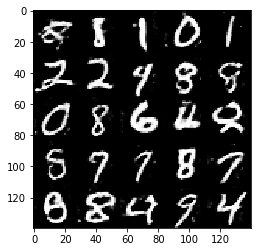

Epoch 2/2... Steps 1810     Discriminator Loss: 1.2474... Generator Loss: 0.4774
Epoch 2/2... Steps 1820     Discriminator Loss: 1.7772... Generator Loss: 0.2450
Epoch 2/2... Steps 1830     Discriminator Loss: 1.0544... Generator Loss: 0.6591
Epoch 2/2... Steps 1840     Discriminator Loss: 1.4464... Generator Loss: 1.5612
Epoch 2/2... Steps 1850     Discriminator Loss: 0.9894... Generator Loss: 1.2453
Epoch 2/2... Steps 1860     Discriminator Loss: 1.4245... Generator Loss: 1.4034
Epoch 2/2... Steps 1870     Discriminator Loss: 0.9997... Generator Loss: 0.7789


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps 10     Discriminator Loss: 6.9259... Generator Loss: 0.0010
Epoch 1/1... Steps 20     Discriminator Loss: 0.2719... Generator Loss: 3.3557
Epoch 1/1... Steps 30     Discriminator Loss: 1.9667... Generator Loss: 0.2285
Epoch 1/1... Steps 40     Discriminator Loss: 1.4750... Generator Loss: 0.3573
Epoch 1/1... Steps 50     Discriminator Loss: 0.6326... Generator Loss: 3.2707
Epoch 1/1... Steps 60     Discriminator Loss: 2.6629... Generator Loss: 0.2291
Epoch 1/1... Steps 70     Discriminator Loss: 1.4838... Generator Loss: 0.8850
Epoch 1/1... Steps 80     Discriminator Loss: 1.5781... Generator Loss: 0.4353
Epoch 1/1... Steps 90     Discriminator Loss: 1.3585... Generator Loss: 0.5816
Epoch 1/1... Steps 100     Discriminator Loss: 1.8267... Generator Loss: 0.2744


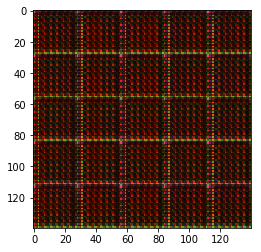

Epoch 1/1... Steps 110     Discriminator Loss: 1.2731... Generator Loss: 0.5584
Epoch 1/1... Steps 120     Discriminator Loss: 1.4372... Generator Loss: 2.3245
Epoch 1/1... Steps 130     Discriminator Loss: 2.1591... Generator Loss: 3.6754
Epoch 1/1... Steps 140     Discriminator Loss: 1.2316... Generator Loss: 1.4215
Epoch 1/1... Steps 150     Discriminator Loss: 0.8989... Generator Loss: 1.4336
Epoch 1/1... Steps 160     Discriminator Loss: 1.1208... Generator Loss: 2.0729
Epoch 1/1... Steps 170     Discriminator Loss: 1.3177... Generator Loss: 2.1301
Epoch 1/1... Steps 180     Discriminator Loss: 2.4153... Generator Loss: 0.1201
Epoch 1/1... Steps 190     Discriminator Loss: 1.0199... Generator Loss: 0.9316
Epoch 1/1... Steps 200     Discriminator Loss: 2.5242... Generator Loss: 0.1991


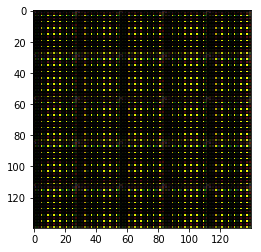

Epoch 1/1... Steps 210     Discriminator Loss: 1.4168... Generator Loss: 0.7052
Epoch 1/1... Steps 220     Discriminator Loss: 1.3623... Generator Loss: 0.5906
Epoch 1/1... Steps 230     Discriminator Loss: 1.2454... Generator Loss: 0.7080
Epoch 1/1... Steps 240     Discriminator Loss: 1.4650... Generator Loss: 0.8088
Epoch 1/1... Steps 250     Discriminator Loss: 1.2542... Generator Loss: 1.4510
Epoch 1/1... Steps 260     Discriminator Loss: 1.1206... Generator Loss: 1.5226
Epoch 1/1... Steps 270     Discriminator Loss: 1.0064... Generator Loss: 1.0591
Epoch 1/1... Steps 280     Discriminator Loss: 1.2649... Generator Loss: 2.2660
Epoch 1/1... Steps 290     Discriminator Loss: 1.3403... Generator Loss: 1.6668
Epoch 1/1... Steps 300     Discriminator Loss: 0.9213... Generator Loss: 1.1136


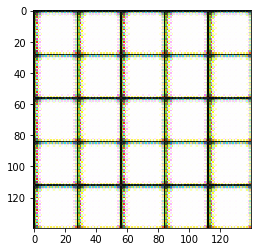

Epoch 1/1... Steps 310     Discriminator Loss: 1.3479... Generator Loss: 1.4974
Epoch 1/1... Steps 320     Discriminator Loss: 0.7930... Generator Loss: 1.2924
Epoch 1/1... Steps 330     Discriminator Loss: 1.0480... Generator Loss: 2.0100
Epoch 1/1... Steps 340     Discriminator Loss: 0.7737... Generator Loss: 1.0748
Epoch 1/1... Steps 350     Discriminator Loss: 0.9371... Generator Loss: 0.9306
Epoch 1/1... Steps 360     Discriminator Loss: 1.5340... Generator Loss: 0.2690
Epoch 1/1... Steps 370     Discriminator Loss: 1.3759... Generator Loss: 0.3682
Epoch 1/1... Steps 380     Discriminator Loss: 1.6138... Generator Loss: 0.2606
Epoch 1/1... Steps 390     Discriminator Loss: 0.7085... Generator Loss: 0.9371
Epoch 1/1... Steps 400     Discriminator Loss: 0.1856... Generator Loss: 2.2464


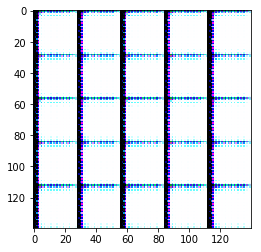

Epoch 1/1... Steps 410     Discriminator Loss: 0.3364... Generator Loss: 1.8097
Epoch 1/1... Steps 420     Discriminator Loss: 1.1657... Generator Loss: 2.4727
Epoch 1/1... Steps 430     Discriminator Loss: 0.3278... Generator Loss: 1.7974
Epoch 1/1... Steps 440     Discriminator Loss: 2.0112... Generator Loss: 0.2000
Epoch 1/1... Steps 450     Discriminator Loss: 0.8472... Generator Loss: 2.4876
Epoch 1/1... Steps 460     Discriminator Loss: 0.3725... Generator Loss: 1.9514
Epoch 1/1... Steps 470     Discriminator Loss: 4.9447... Generator Loss: 5.1693
Epoch 1/1... Steps 480     Discriminator Loss: 1.0553... Generator Loss: 1.2007
Epoch 1/1... Steps 490     Discriminator Loss: 1.0543... Generator Loss: 1.1340
Epoch 1/1... Steps 500     Discriminator Loss: 1.2044... Generator Loss: 1.5079


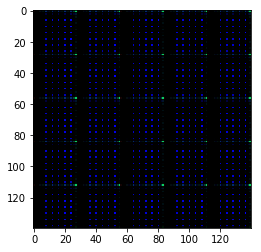

Epoch 1/1... Steps 510     Discriminator Loss: 0.6149... Generator Loss: 3.5351
Epoch 1/1... Steps 520     Discriminator Loss: 2.3238... Generator Loss: 0.3528
Epoch 1/1... Steps 530     Discriminator Loss: 1.4783... Generator Loss: 0.7079
Epoch 1/1... Steps 540     Discriminator Loss: 1.4019... Generator Loss: 0.5796
Epoch 1/1... Steps 550     Discriminator Loss: 0.9961... Generator Loss: 1.8861
Epoch 1/1... Steps 560     Discriminator Loss: 0.8185... Generator Loss: 1.1831
Epoch 1/1... Steps 570     Discriminator Loss: 0.9999... Generator Loss: 1.1554
Epoch 1/1... Steps 580     Discriminator Loss: 1.9601... Generator Loss: 1.5177
Epoch 1/1... Steps 590     Discriminator Loss: 0.9026... Generator Loss: 1.5777
Epoch 1/1... Steps 600     Discriminator Loss: 1.1079... Generator Loss: 1.7157


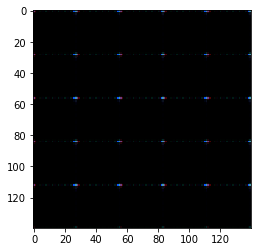

Epoch 1/1... Steps 610     Discriminator Loss: 0.8421... Generator Loss: 1.3203
Epoch 1/1... Steps 620     Discriminator Loss: 1.2139... Generator Loss: 0.7147
Epoch 1/1... Steps 630     Discriminator Loss: 2.0086... Generator Loss: 0.2747
Epoch 1/1... Steps 640     Discriminator Loss: 1.1936... Generator Loss: 0.4907
Epoch 1/1... Steps 650     Discriminator Loss: 1.5322... Generator Loss: 0.3306
Epoch 1/1... Steps 660     Discriminator Loss: 1.1755... Generator Loss: 2.9717
Epoch 1/1... Steps 670     Discriminator Loss: 1.3208... Generator Loss: 0.9623
Epoch 1/1... Steps 680     Discriminator Loss: 1.2796... Generator Loss: 0.7064
Epoch 1/1... Steps 690     Discriminator Loss: 1.2490... Generator Loss: 1.3725
Epoch 1/1... Steps 700     Discriminator Loss: 0.8585... Generator Loss: 1.2659


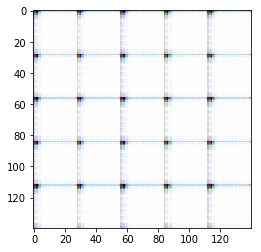

Epoch 1/1... Steps 710     Discriminator Loss: 1.4536... Generator Loss: 0.7688
Epoch 1/1... Steps 720     Discriminator Loss: 0.7757... Generator Loss: 1.4939
Epoch 1/1... Steps 730     Discriminator Loss: 1.1885... Generator Loss: 0.7683
Epoch 1/1... Steps 740     Discriminator Loss: 1.2637... Generator Loss: 0.6993
Epoch 1/1... Steps 750     Discriminator Loss: 1.3880... Generator Loss: 0.4655
Epoch 1/1... Steps 760     Discriminator Loss: 0.8011... Generator Loss: 0.9932
Epoch 1/1... Steps 770     Discriminator Loss: 0.9997... Generator Loss: 1.4129
Epoch 1/1... Steps 780     Discriminator Loss: 1.2384... Generator Loss: 0.6215
Epoch 1/1... Steps 790     Discriminator Loss: 0.9538... Generator Loss: 0.9061
Epoch 1/1... Steps 800     Discriminator Loss: 1.4505... Generator Loss: 0.5620


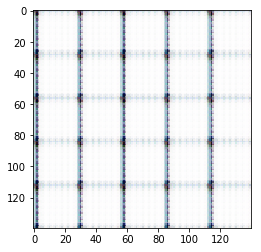

Epoch 1/1... Steps 810     Discriminator Loss: 0.9311... Generator Loss: 1.6528
Epoch 1/1... Steps 820     Discriminator Loss: 1.3583... Generator Loss: 0.6264
Epoch 1/1... Steps 830     Discriminator Loss: 1.3031... Generator Loss: 0.5202
Epoch 1/1... Steps 840     Discriminator Loss: 0.5764... Generator Loss: 1.6156


KeyboardInterrupt: 

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.